Data Processing

In [94]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [95]:
# Mount drive to import data file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
# Importing data
# retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
import torchvision.transforms as transforms
import torchvision.datasets as d
from torch.utils.data import DataLoader, Dataset, Subset

# https://pytorch.org/vision/0.9/transforms.html
# https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html
# https://discuss.pytorch.org/t/resizing-dataset/75620/4

# transform images to rescale, resize, normalize
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load your dataset with the defined transformations
# my path is /content/drive/My Drive/Colab Notebooks/APS360/Data NvsP
# dear teammates will have to make their own path with the data that's been shared
dataset = d.ImageFolder('/content/drive/My Drive/Colab Notebooks/APS360/Data NvsP', transform=transform)

In [97]:
# pick 80/10/10 split, remove 90% of the dataset to reduce size of dataset due to computational cost
torch.manual_seed(1000)
extra, train, val, test = torch.utils.data.random_split(dataset, [0.90, 0.08, 0.01, 0.01])
print(len(train))
print(len(val))
print(len(test))

241
30
30


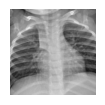

0


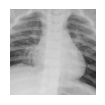

1


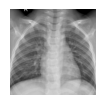

0


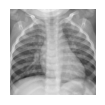

0


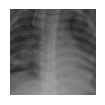

1


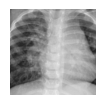

1


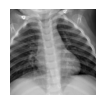

0


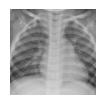

0


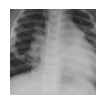

1


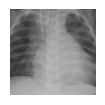

1


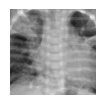

1


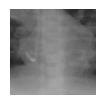

1


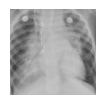

1


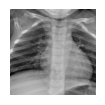

0


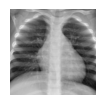

0


In [98]:
# Function to denormalize and convert tensor to numpy array
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(img)
    plt.show()

# Visualize the first 15 images
k = 0
for img, label in train:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    imshow(img)
    print(label)

    k += 1
    if k > 14:
        break

In [99]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if isinstance(image, torch.Tensor):
          image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label

Baseline Model

In [69]:
# https://discuss.pytorch.org/t/how-to-use-svm-for-classifying-image/49485/2

Primary Model

In [100]:
# model name function from lab 2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# evaluate function from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# from tut 3
def get_accuracy(model, train=False):
    if train:
        data = train
    else:
        data = val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# train net function from lab 2
def train_net(net, batchsize, lr, epoch, train, val):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Comvert data to tensors and load the batches
    traindataset=Dataset(train, transform=transform)
    valdataset=Dataset(val, transform=transform)
    trainloader=torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader=torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    #set up error and loss array
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    #iterate through and train the data
    for epoch in range(epoch):
        total_train_samples=0
        i=0
        for image, label in trainloader:
            optimizer.zero_grad()
            output=net(image)
            loss=criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch]+=loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch] += (predicted != label).sum().item()
            total_train_samples+=len(label)
            i+=1
        #calculate error loss for each epoch
        train_loss[epoch]/=(i+1)
        train_error[epoch]/=total_train_samples
        #evaluate v=on validation for each epoch
        val_err[epoch], val_loss[epoch] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Train Error: {train_error[epoch]}, Val Loss: {val_loss[epoch]}, Val Error: {val_err[epoch]}")
        #checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch)
        torch.save(net.state_dict(), model_path)
    #save the model to plot later
    epochs = np.arange(1, epoch + 1)
    a=np.savetxt("{}_train_err.csv".format(model_path), train_error)
    b=np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    c=np.savetxt("{}_val_err.csv".format(model_path), val_err)
    d=np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [71]:
#Convolutional Neural Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [101]:
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net=Net()
train_net(net, 12, 0.01, 20, small_train, small_val)

Epoch 1: Train Loss: 0.3445354104042053, Train Error: 0.2, Val Loss: 0.6774588823318481, Val Error: 0.4
Epoch 2: Train Loss: 0.31331363320350647, Train Error: 0.1, Val Loss: 0.6636346578598022, Val Error: 0.4
Epoch 3: Train Loss: 0.2737836241722107, Train Error: 0.0, Val Loss: 0.6583260297775269, Val Error: 0.3
Epoch 4: Train Loss: 0.21821165084838867, Train Error: 0.0, Val Loss: 0.6524325609207153, Val Error: 0.4
Epoch 5: Train Loss: 0.15584467351436615, Train Error: 0.0, Val Loss: 0.6365581154823303, Val Error: 0.5
Epoch 6: Train Loss: 0.09655485302209854, Train Error: 0.0, Val Loss: 0.6130272150039673, Val Error: 0.4
Epoch 7: Train Loss: 0.04964211583137512, Train Error: 0.0, Val Loss: 0.5994174480438232, Val Error: 0.4
Epoch 8: Train Loss: 0.02154567278921604, Train Error: 0.0, Val Loss: 0.599917471408844, Val Error: 0.4
Epoch 9: Train Loss: 0.008105062879621983, Train Error: 0.0, Val Loss: 0.6119469404220581, Val Error: 0.5
Epoch 10: Train Loss: 0.0027909898199141026, Train Error:

Hyperparameter Tuning

In [74]:
#From lab 2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [103]:
# Settings from Lab 3
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.name = "Net1"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1=Net1()
# small_train = Subset(train, range(10))
# small_val = Subset(val, range(10))

train_net(net1, 64, 0.01, 30, train, val)

Epoch 1: Train Loss: 0.5379950642585755, Train Error: 0.44398340248962653, Val Loss: 0.6330038905143738, Val Error: 0.4
Epoch 2: Train Loss: 0.4913833498954773, Train Error: 0.2863070539419087, Val Loss: 0.6083232164382935, Val Error: 0.23333333333333334
Epoch 3: Train Loss: 0.4129572451114655, Train Error: 0.22821576763485477, Val Loss: 0.4379040002822876, Val Error: 0.23333333333333334
Epoch 4: Train Loss: 0.4638055801391602, Train Error: 0.33195020746887965, Val Loss: 0.4304982125759125, Val Error: 0.23333333333333334
Epoch 5: Train Loss: 0.34263756275177004, Train Error: 0.21991701244813278, Val Loss: 0.4294574558734894, Val Error: 0.26666666666666666
Epoch 6: Train Loss: 0.2561331570148468, Train Error: 0.07883817427385892, Val Loss: 0.29734399914741516, Val Error: 0.1
Epoch 7: Train Loss: 0.12253363132476806, Train Error: 0.029045643153526972, Val Loss: 0.451305091381073, Val Error: 0.13333333333333333
Epoch 8: Train Loss: 0.08864670842885972, Train Error: 0.04564315352697095, Va

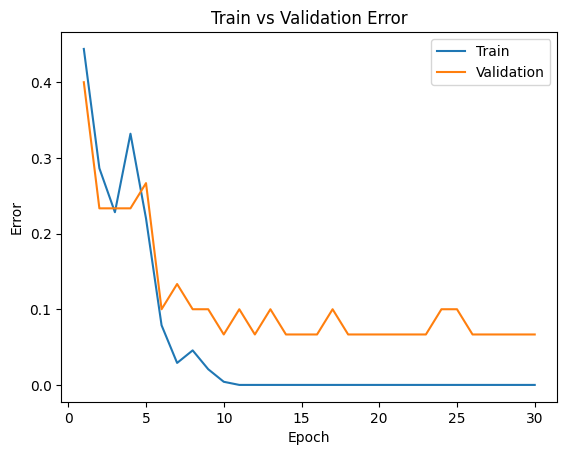

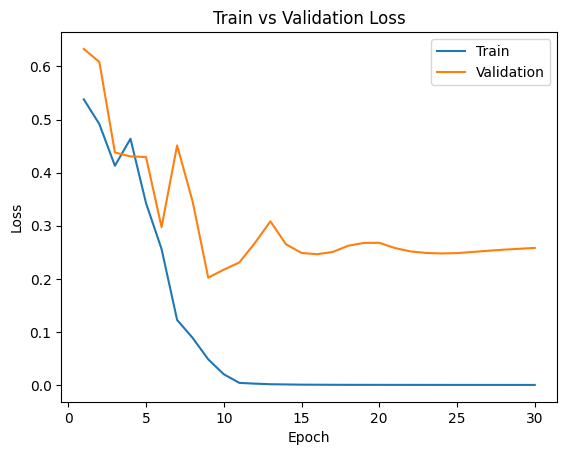

In [104]:
# example
model_path = get_model_name("Net1", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)